# Building an MPS as a tree and using TEBD for time-evolution
A matrix product state (MPS) is a binary tree. Therefore, we can simulate it using `PyTreeNet`. We recommend to use tensor network libraries specialised on MPS for serious simulation, due to a higher efficiency. However, utilising `PyTreeNet` on MPS is useful as an illustrative example and to test the code for mistakes, by comparing to the results yielded by the easy to implement few-site dynamics.

In [1]:
# Import PyTreeNet from local folders
import sys
sys.path.append('..')
import pytreenet as ptn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.linalg import expm
from copy import copy, deepcopy

We want to analyse a chain of $N$-many qubits that evolves under an Ising Hamiltonian of the form
$$
H = -J \sum_{n=0}^{N-2} X_n X_{n+1} - g \sum_{n=0}^{N-1} Z_n.
$$

As a first step we will initalise a tree tensor network (TTN) representing an MPS in the initial state where all qubits are in the state $|0>$

## Setting up and running TEBD

Since the total zero state is a product state, we can create its MPS form by adding one node after the other to a tree tensor network state.

In [2]:
num_sites = 7

zero_state = np.asarray([1, 0])

# This needs to become a 3-tensor with leg order (left_virt, physical, right_virt)
# Initially the virtual legs are trivial, i.e. of dimension 1
zero_state = zero_state.reshape((1,2,1))

# Now the TTN is created an initially empty
mps = ptn.TreeTensorNetworkState()

# We have to add the sites one by one.
for site in range(num_sites):
    identifier = "site" + str(site)
    local_state = copy(zero_state)
    # A node is only linked to an actual tensor, once it is added to a TTN.
    node = ptn.Node(identifier = identifier)
    
    if site == 0:
        # Open boundary conditions on first site        
        mps.add_root(node, local_state[0])
        
    elif 0 < site:
        parent_id = "site" + str(site - 1)
        if site == num_sites - 1:
            # Open boundary conditions on last site
            mps.add_child_to_parent(node, local_state[:,:,0], 0, parent_id, 2)
        else:
            if site == 1:
                # Due to boundary condition on first site
                mps.add_child_to_parent(node, local_state, 0, parent_id, 1)
            else:
                mps.add_child_to_parent(node, local_state, 0, parent_id, 2)

We find the TTN contains all the desired sites as nodes and is normalised. Note that the open leg was moved to be the last leg rather then the middle one, which is commonly done in MPS libraries.

In [3]:
node_shapes = {node_id: mps.nodes[node_id].shape for node_id in mps.nodes}
print(node_shapes)

print(f"Norm = {np.sqrt(mps.scalar_product())}")

{'site0': (1, 2), 'site1': (1, 1, 2), 'site2': (1, 1, 2), 'site3': (1, 1, 2), 'site4': (1, 1, 2), 'site5': (1, 1, 2), 'site6': (1, 2)}
Norm = (1+0j)


For TEBD the time-evolution is computed via a Trotter splitting. Deciding on the exact form of the splitting is a balancing act between accuracy and computing resources. As a simple case we will choose the first order splitting:
$$
U(\delta t) = e^{-i\delta t H} = \prod_{n=0}^{N-1} e^{i\delta t \, J X_n X_{n+1}} \prod_{n=0}^{N-1} e^{i\delta t \, g Z_n} + \mathcal{O} (\delta t^2)
$$
We need to define the operators making up the Hamiltonian of our model. Every term is its own operator and in tensor product form.

In [4]:
# Define constants
mJ = -1.5
mg = -0.5

# Define operators
X, _, Z = ptn.pauli_matrices()

gZ = mg * Z

hamiltonian_operators = []

# Add the two-site interaction
for site in range(0,num_sites-1): # There is no interaction of the form X_N*X_{N+1}
    term = ptn.TensorProduct({"site" + str(site): mJ * X, "site" + str(site +1): X})
    hamiltonian_operators.append(term)
    
# Add local interactions
for site in range(0,num_sites):
    term = ptn.TensorProduct({"site" + str(site): gZ})
    hamiltonian_operators.append(term)
    
print(hamiltonian_operators)

[{'site0': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site1': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site1': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site2': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site2': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site3': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site3': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site4': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site4': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site5': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site5': array([[-0. +0.j, -1.5+0.j],
       [-1.5+0.j, -0. +0.j]]), 'site6': array([[0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j]])}, {'site0': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j]])}, {'site1': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j]])}, {'site2': array([[-0.5+0.j, -0. +0.j],
       [-0. +0.j,  0.5-0.j

Since TEBD is based on splitting the terms one by one, we need to define, in which order the terms are to be applied.

In [5]:
# Now we initialise the splitting order for both splittings
splitting1st = [2*i for i in range(0, int(num_sites/2))]
splitting1st.extend([2*i +1 for i in range(0, int(num_sites/2))])
splitting1st.extend([i + num_sites -1 for i in range(0,num_sites)])
print("1st order splitting:", splitting1st)

# Thus we have everything required for the TrotterSplitting which holds everything required for the splitting.
# Note that for higher order, factors can be added to the splitting and we can have swap gates applied in between
# two operators.
trotter1st = ptn.TrotterSplitting(hamiltonian_operators, splitting1st)

1st order splitting: [0, 2, 4, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12]


Finally we can set up the TEBD simulation.

In [6]:
# Time parameters
time_step_size = 0.001
final_time = 1

# Truncation parameters
max_bond_dim = 20
rel_tol = 0.000001

# We want to observe the evolution of the Z-operator expectation at each site.
tebd_operators = [ptn.TensorProduct({node_id: Z}) for node_id in mps.nodes]

# We instantiate the TEBD simulations. To keep them independent, the MPS has to be copied.
tebd_sim_1st = ptn.TEBD(deepcopy(mps), trotter1st, time_step_size=time_step_size, final_time=final_time,
                        operators=tebd_operators, max_bond_dim=max_bond_dim, rel_tol=rel_tol)

# After the set up is complete, we merely have to run the simulation
tebd_sim_1st.run()

  1%|▏         | 15/1001 [00:00<00:06, 149.44it/s]

100%|██████████| 1001/1001 [00:06<00:00, 148.55it/s]


## Running the reference matrix vector computation
### Non-Trotterised
As a reference we will run a computation on a full state vector. Thus we have to reinitialise the initial state:

In [7]:
zero_state = np.asarray([1,0])
ref_state = zero_state

for site in range(1, num_sites):
    ref_state = np.kron(ref_state, zero_state)
    
print(f"Initial state {ref_state} is a vector with 2^{num_sites}={len(ref_state)} entries.")

Initial state [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] is a vector with 2^7=128 entries.


Furthermore we need to initialise the Hamiltonian as a matrix:

In [8]:
ref_hamiltonian = np.zeros((2**num_sites, 2**num_sites), dtype=complex)

I = np.eye(2)
J = -mJ

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        
        if site2 == site:
            operator = np.kron(operator, gZ)
        else:
            operator = np.kron(operator, I)
    
    ref_hamiltonian += operator
    
print(f"The Hamiltonian is a {ref_hamiltonian.shape}-shaped matrix and contains (2^{num_sites})^2={len(ref_state)**2} entries.")

The Hamiltonian is a (128, 128)-shaped matrix and contains (2^7)^2=16384 entries.


We also have to compute the Hamiltonian's exponent. When using the `TEBD`-class this happened automatically internally.

In [9]:
exp_operator = expm(-1j*time_step_size*ref_hamiltonian)

As a final step of the set-up we have to define the operators from which we desire the expectation values.

In [10]:
operators = []

for sites in range(num_sites):
    site_operator = np.asarray([1])
    for sites2 in range(num_sites):
        if sites2 == sites:
            site_operator = np.kron(site_operator, Z)
        else:
            site_operator = np.kron(site_operator, I)
            
    operators.append(site_operator)

We can finally run the time-evolution.

In [11]:
num_time_steps = int(np.ceil(final_time / time_step_size))

results = np.zeros((len(operators) + 1, num_time_steps + 1), dtype=complex)

for time_step in range(num_time_steps + 1):
    if time_step != 0:
        ref_state = exp_operator @ ref_state
    
    conj_state = np.conjugate(ref_state.T)
    for i, operator in enumerate(operators):
        results[i,time_step] = conj_state @ operator @ ref_state
        
    results[-1,time_step] = time_step * time_step_size
    
results.shape

(8, 1001)

### Trotterised Computation
To ensure that the error is fully due to the Trotterisation, we run a time-evolution that evolves according to a Trotterisation.

In [12]:
# Creating the Trotter Steps
trotter_operators = []

# Two-site terms
for site in range(0,num_sites-1):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, J*X)
        elif site2 == site+1:
            operator = np.kron(operator, X)
        else:
            operator = np.kron(operator, I)
    trotter_operators.append(operator)
    
# Single-site terms
for site in range(0,num_sites):
    operator = np.asarray([1])
    for site2 in range(0,num_sites):
        if site2 == site:
            operator = np.kron(operator, gZ)
        else:
            operator = np.kron(operator, I)   
    trotter_operators.append(operator)

trotter_unitaries = [expm(-1j*time_step_size*term) for term in trotter_operators]
results_trotterised = np.zeros((len(operators) + 1, num_time_steps + 1), dtype=complex)

ref_state_trotter = zero_state
for site in range(1, num_sites):
    ref_state_trotter = np.kron(ref_state_trotter, zero_state)

for time_step in range(num_time_steps + 1):
    if time_step != 0:
        for unitary in trotter_unitaries:
            ref_state_trotter = unitary @ ref_state_trotter
    
    conj_state = np.conjugate(ref_state_trotter.T)
    for i, operator in enumerate(operators):
        results_trotterised[i,time_step] = conj_state @ operator @ ref_state_trotter
        
    results_trotterised[-1,time_step] = time_step * time_step_size

results_trotterised.shape

(8, 1001)

## Extracting results from TEBD
The expectation values and times are saved in the attribute `TEBD.results`:

In [13]:
times = [time.real for time in tebd_sim_1st.results[-1]]

exp_val_Z_0 = [exp_val.real for exp_val in tebd_sim_1st.results[0]]

The operators of which expectation values were calculated are hermitian, so their expectation values should be real numbers:

In [14]:
max([exp_val.imag for exp_val in tebd_sim_1st.results[0]])

2.7755575615628914e-16

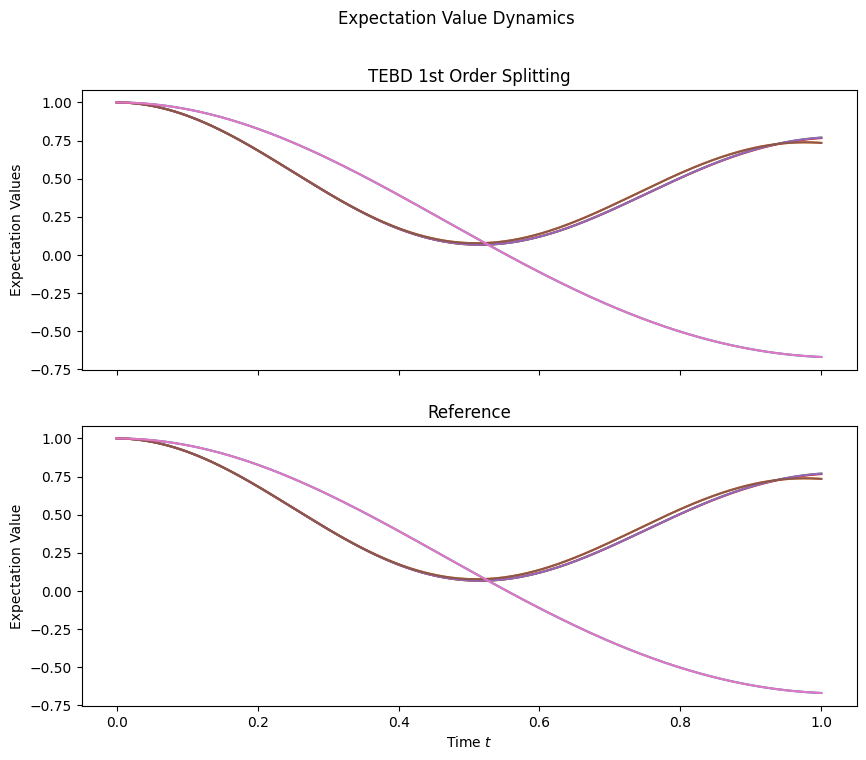

In [15]:
ref_times = [time.real for time in results[-1]]

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10,8))

fig.suptitle("Expectation Value Dynamics")

for site in range(num_sites):
    axs[0].plot(times, [exp_val.real for exp_val in tebd_sim_1st.results[site]])

axs[0].set_ylabel("Expectation Values")
axs[0].set_title("TEBD 1st Order Splitting")

for site in range(num_sites):
    axs[1].plot(ref_times, [exp_val.real for exp_val in results[site]])

axs[1].set_xlabel("Time $t$")
axs[1].set_ylabel("Expectation Value")
axs[1].set_title("Reference")

plt.show()

We can already see that both are very similar. Let us compare the actual errors:

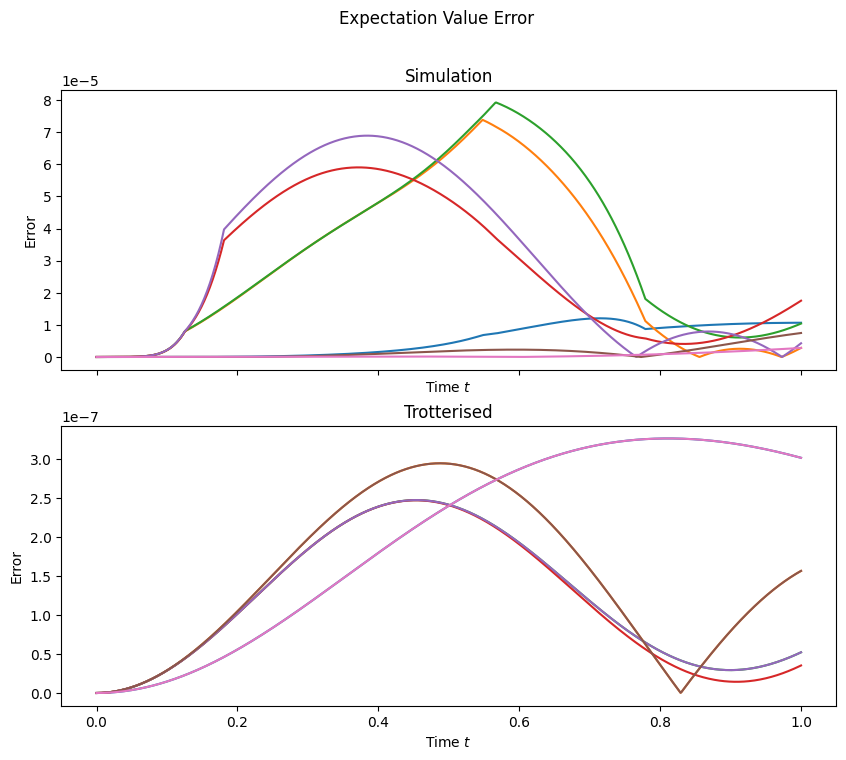

In [16]:
errors_1st = results[0:-1] - tebd_sim_1st.results[0:-1]
errors_trott = results_trotterised[0:-1] - results[0:-1]

fig2, axs2 = plt.subplots(2,1, sharex=True, sharey=False, figsize=(10,8))

fig2.suptitle("Expectation Value Error")

for error_row in errors_1st:
    axs2[0].plot(times, [abs(error) for error in error_row])
axs2[0].set_xlabel("Time $t$")
axs2[0].set_ylabel("Error")
axs2[0].set_title("Simulation")

for error_row in errors_trott:
    axs2[1].plot(times, [abs(error) for error in error_row])
axs2[1].set_xlabel("Time $t$")
axs2[1].set_ylabel("Error")
axs2[1].set_title("Trotterised")


plt.show()

We can see that the error for all expectation values is low, i.e. $\text{err} \sim 10^{-5}$.

# Tree MPS
To trust the algorithm a bit more, we can consider the MPS is a different form. Rather than the root having a single site, it has two, and from there every node has a single child.

In [17]:
assert num_sites % 2 == 1
zero_state = np.asarray([1, 0]).reshape((1,1,2))
mps_tree = ptn.TreeTensorNetworkState()

middle_site = int(num_sites / 2)
root_node = ptn.Node(identifier="site" + str(middle_site))
mps_tree.add_root(root_node, deepcopy(zero_state))

for site in range(middle_site):
    left_site = middle_site - 1 - site
    right_site = middle_site + 1 + site
    if left_site == 0:
        tensor = deepcopy(zero_state[:,0,:])
    else:
        tensor = deepcopy(zero_state)
    left_node = ptn.Node(identifier="site" + str(left_site))
    right_node = ptn.Node(identifier="site" + str(right_site))
    if site == 0:
        left_parent_leg = 0
    else:
        left_parent_leg = 1
    mps_tree.add_child_to_parent(left_node, deepcopy(tensor), 0,
                                 "site" + str(left_site+1), left_parent_leg)
    mps_tree.add_child_to_parent(right_node, tensor, 0,
                                 "site" + str(right_site-1), 1)

Since we use the Hamiltonian and do not require SWAP-gates to achieve nearest neighbour interactions, we can reuse the original trotterisation and operators.

In [18]:
import pytreenet as ptn

tebd_tree = ptn.TEBD(deepcopy(mps_tree), trotter1st, time_step_size=time_step_size,
                     final_time=final_time, operators=tebd_operators,
                     max_bond_dim=max_bond_dim, rel_tol=rel_tol)
tebd_tree.run()

  1%|▏         | 14/1001 [00:00<00:07, 137.63it/s]

100%|██████████| 1001/1001 [00:07<00:00, 142.62it/s]


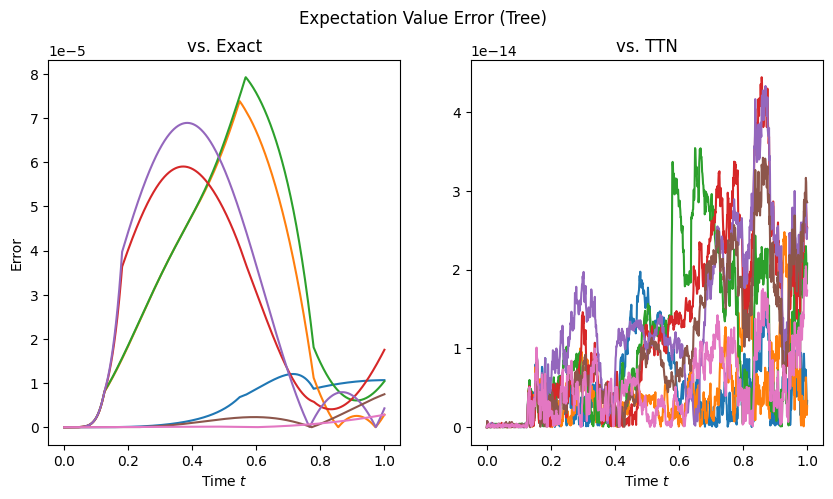

In [19]:
errors_tree = results[0:-1] - tebd_tree.results[0:-1]
errors_tns = tebd_sim_1st.results[0:-1] - tebd_tree.results[0:-1]

fig3, ax3 = plt.subplots(1, 2, sharex=True, figsize=(10,5))

fig3.suptitle("Expectation Value Error (Tree)")

for error_row in errors_tree:
    ax3[0].plot(times, [abs(error) for error in error_row])
ax3[0].set_ylabel("Error")
ax3[0].set_xlabel("Time $t$")
ax3[0].set_title("vs. Exact")

for error_row in errors_tns:
    ax3[1].plot(times, [abs(error) for error in error_row])
ax3[1].set_xlabel("Time $t$")
ax3[1].set_title("vs. TTN")

plt.show()

We can see that this more complicated but equivalent tree structure yields the exact same results, as it should be.

## Further benchmarking
We can create two more sanity checks. The first is testing the convergence of our results with increasing bond-dimension, while the second one is the dependency of the error with respect to the time step $\delta t$.

### Convergence for increasing Bond Dimension

In [20]:
# The maximum bond dimension required to exactly represent the states is
max_max_bond_dim = 2 ** middle_site
max_bond_dims = range(1, max_max_bond_dim + 1)

results_mps = np.zeros((len(max_bond_dims), int(final_time / time_step_size) + 1))
results_tree = np.zeros((len(max_bond_dims), int(final_time / time_step_size) + 1))

for i, max_bond_dim in tqdm(enumerate(max_bond_dims)):
    tebd_mps = ptn.TEBD(deepcopy(mps), trotter1st, time_step_size,
                        final_time, [tebd_operators[middle_site]],
                        max_bond_dim=max_bond_dim, rel_tol=rel_tol)
    tebd_tree = ptn.TEBD(deepcopy(mps_tree), trotter1st, time_step_size,
                        final_time, [tebd_operators[middle_site]],
                        max_bond_dim=max_bond_dim, rel_tol=rel_tol)
    tebd_mps.run(pgbar=False)
    tebd_tree.run(pgbar=False)
    results_mps[i,:] = np.absolute(tebd_mps.results[0,:])
    results_tree[i,:] = np.absolute(tebd_tree.results[0,:])

8it [00:38,  4.79s/it]


/home/ge24fum/Documents/Github/PyTreeNet/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


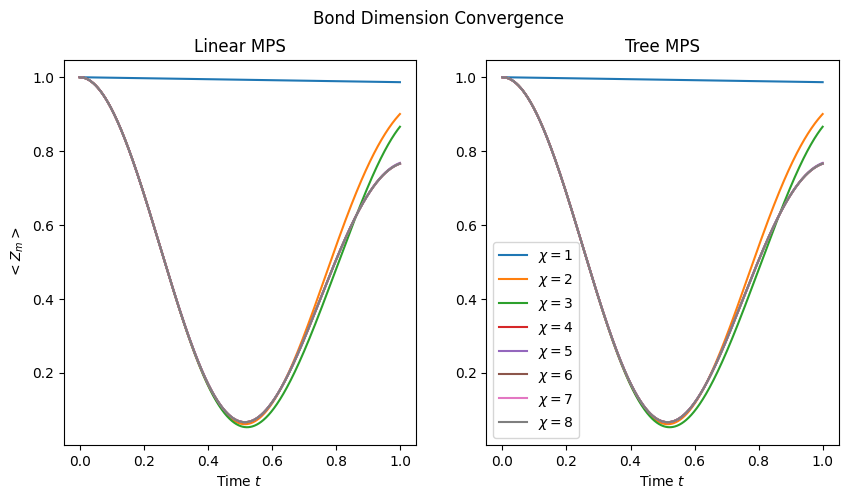

In [21]:
fig4, ax4 = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig4.suptitle("Bond Dimension Convergence")

times = tebd_mps.results[-1,:]
for i, max_bond_dim in enumerate(max_bond_dims):
    ax4[0].plot(times, results_mps[i,:])
ax4[0].set_ylabel(f"$<Z_m>$")
ax4[0].set_xlabel("Time $t$")
ax4[0].set_title("Linear MPS")

for i, max_bond_dim in enumerate(max_bond_dims):
    ax4[1].plot(times, results_tree[i,:], label="$\chi=$" + str(max_bond_dim))
ax4[1].set_xlabel("Time $t$")
ax4[1].set_title("Tree MPS")

plt.legend()
plt.show()

We can see that the dynamics converge with increasing bond-dimension and are fully converged for $\chi = 4$ for human perception.

### Error Dependence on Time Step
For a fixed final time, the error of our dynamics should increase linearly with $\delta t$.

In [22]:
max_bond_dim = 4
time_step_sizes = np.arange(final_time / 1000 * 2,
                            final_time / 10 + final_time / 1000 * 2,
                            final_time / 1000 * 2)

ref_result = results[middle_site,-1]
results_mps = []
results_tree = []

for i, time_step_size in tqdm(enumerate(time_step_sizes)):
    tebd_mps = ptn.TEBD(deepcopy(mps), trotter1st, time_step_size,
                        final_time, [tebd_operators[middle_site]],
                        max_bond_dim=max_bond_dim, rel_tol=rel_tol)
    tebd_tree = ptn.TEBD(deepcopy(mps_tree), trotter1st, time_step_size,
                        final_time, [tebd_operators[middle_site]],
                        max_bond_dim=max_bond_dim, rel_tol=rel_tol)
    tebd_mps.run(pgbar=False)
    tebd_tree.run(pgbar=False)
    results_mps.append(np.absolute(tebd_mps.results[0,-1] - ref_result))
    results_tree.append(np.absolute(tebd_tree.results[0,-1] - ref_result))


50it [00:11,  4.42it/s]


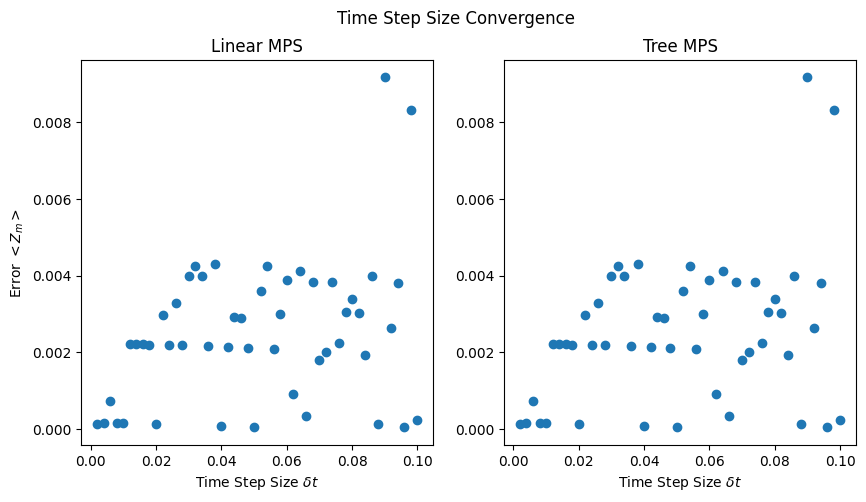

In [23]:
fig5, ax5 = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig5.suptitle("Time Step Size Convergence")

ax5[0].plot(time_step_sizes, results_mps, "o")
ax5[0].set_ylabel(f"Error $<Z_m>$")
ax5[0].set_xlabel("Time Step Size $\delta t$")
ax5[0].set_title("Linear MPS")

ax5[1].plot(time_step_sizes, results_tree, "o")
ax5[1].set_xlabel("Time Step Size $\delta t$")
ax5[1].set_title("Tree MPS")

plt.show()